# Algorithms for Big Data - Exercise 7
This lecture is focused on the more advanced examples of the RNN usage for text data anylysis.

We will deal with the sentiment analysis task using Twitter data.

You can download the dataset from [this link](https://github.com/MohamedAfham/Twitter-Sentiment-Analysis-Supervised-Learning/tree/master/Data)


[Open in Google colab](https://colab.research.google.com/github/rasvob/2020-21-ARD/blob/master/abd_07.ipynb)
[Download from Github](https://github.com/rasvob/2020-21-ARD/blob/master/abd_07.ipynb)

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt # plotting
import matplotlib.image as mpimg # images
import numpy as np #numpy
import seaborn as sns
import tensorflow.compat.v2 as tf #use tensorflow v2 as a main 
import tensorflow.keras as keras # required for high level applications
from sklearn.model_selection import train_test_split # split for validation sets
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import normalize # normalization of the matrix
import scipy
import pandas as pd
from collections import Counter

tf.version.VERSION

'2.8.0'

In [2]:
import unicodedata, re, string
import nltk
from textblob import TextBlob

In [3]:
def show_history(history):
    plt.figure()
    for key in history.history.keys():
        plt.plot(history.epoch, history.history[key], label=key)
    plt.legend()
    plt.tight_layout()

In [4]:
class Mish(keras.layers.Activation):
    '''
    Mish Activation Function.
    .. math::
        mish(x) = x * tanh(softplus(x)) = x * tanh(ln(1 + e^{x}))
    Shape:
        - Input: Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
        - Output: Same shape as the input.
    Examples:
        >>> X = Activation('Mish', name="conv1_act")(X_input)
    '''

    def __init__(self, activation, **kwargs):
        super(Mish, self).__init__(activation, **kwargs)
        self.__name__ = 'Mish'


def mish(inputs):
    return inputs * tf.math.tanh(tf.math.softplus(inputs))

keras.utils.get_custom_objects().update({'mish': Mish(mish)})

In [5]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [6]:
df = pd.read_csv('https://raw.githubusercontent.com/rasvob/2020-21-ARD/master/datasets/train_tweets.csv')

In [7]:
df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


# Let's take a look at the data

In [8]:
df.shape

(31962, 3)

## We can see that the classification task is highly imbalanced, because we have only 2242 negative tweets compared with positive one

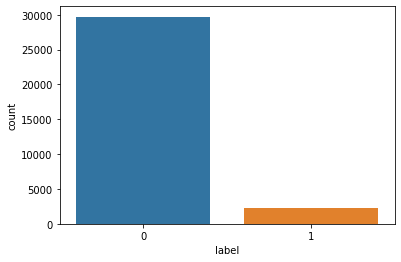

In [9]:
sns.countplot(x='label', data=df)

In [10]:
df.label.value_counts()

0    29720
1     2242
Name: label, dtype: int64

In [11]:
df['length'] = df.tweet.apply(len)

### We can see that the sentences are of similar lengths

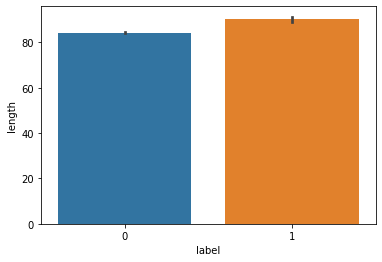

In [12]:
sns.barplot(x='label', y='length', data = df)

# We can see that the text data are full of noise

- Social posts suffer the most from this effect
- The text is full of hashtags, emojis, @mentions and so on
- These parts usually don't influence the sentiment score by much
- Although most advanced models usually extract even this features because e.g. emojis can help you with the sarcasm understanding

In [14]:
for x in df.loc[:10, 'tweet']:
    print(x)
    print('---------')

 @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run
---------
@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked
---------
  bihday your majesty
---------
#model   i love u take with u all the time in urð±!!! ððððð¦ð¦ð¦  
---------
 factsguide: society now    #motivation
---------
[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo  
---------
 @user camping tomorrow @user @user @user @user @user @user @user dannyâ¦
---------
the next school year is the year for exams.ð¯ can't think about that ð­ #school #exams   #hate #imagine #actorslife #revolutionschool #girl
---------
we won!!! love the land!!! #allin #cavs #champions #cleveland #clevelandcavaliers  â¦ 
---------
 @user @user welcome here !  i'm   it's so #gr8 ! 
---------
 â #ireland consumer price index (mom) climbed f

## Stemming
Stemming is the process of producing morphological variants of a root/base word. Stemming programs are commonly referred to as stemming algorithms or stemmers. A stemming algorithm reduces the words “chocolates”, “chocolatey”, “choco” to the root word, “chocolate” and “retrieval”, “retrieved”, “retrieves” reduce to the stem “retrieve”,

## Lemmatization 
Lemmatization is the process of grouping together the different inflected forms of a word so they can be analysed as a single item. Lemmatization is similar to stemming but it brings context to the words. So it links words with similar meaning to one word.

Examples of lemmatization:

- rocks : rock
- corpora : corpus
- better : good

## Both techiques can be used in the preprocessing pipeline
You have to decide if it is beneficial to you, because this steps leads to some generalization of the data by itself. You will definitely lose some pieces of the information. If you use some form of embedding like Word2Vec or Glove, it is better to skip this steps because the embedding vocabulary skipped it as well.

In [15]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_numbers(words):
    """Remove all interger occurrences in list of tokenized words with textual representation"""
    new_words = []
    for word in words:
        new_word = re.sub("\d+", "", word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
# words = remove_punctuation(words)
    words = remove_numbers(words)
#    words = remove_stopwords(words)
    return words

def form_sentence(tweet):
    tweet_blob = TextBlob(tweet)
    return tweet_blob.words

# Tokenize sentences and remove puncuation by TextBlob library

In [16]:
df['Words'] = df['tweet'].apply(form_sentence)

In [17]:
df.head()

,id,label,tweet,length,Words
0,1,0,@user when a father is dysfunctional and is s...,102,"[user, when, a, father, is, dysfunctional, and..."
1,2,0,@user @user thanks for #lyft credit i can't us...,122,"[user, user, thanks, for, lyft, credit, i, ca,..."
2,3,0,bihday your majesty,21,"[bihday, your, majesty]"
3,4,0,#model i love u take with u all the time in ...,86,"[model, i, love, u, take, with, u, all, the, t..."
4,5,0,factsguide: society now #motivation,39,"[factsguide, society, now, motivation]"


# Normalize sentences 
- We want only ascii, lowercase and no numbers

## You can experiments with different preprocess steps!

In [18]:
df['Words_normalized'] = df['Words'].apply(normalize)

In [19]:
df.head()

,id,label,tweet,length,Words,Words_normalized
0,1,0,@user when a father is dysfunctional and is s...,102,"[user, when, a, father, is, dysfunctional, and...","[user, when, a, father, is, dysfunctional, and..."
1,2,0,@user @user thanks for #lyft credit i can't us...,122,"[user, user, thanks, for, lyft, credit, i, ca,...","[user, user, thanks, for, lyft, credit, i, ca,..."
2,3,0,bihday your majesty,21,"[bihday, your, majesty]","[bihday, your, majesty]"
3,4,0,#model i love u take with u all the time in ...,86,"[model, i, love, u, take, with, u, all, the, t...","[model, i, love, u, take, with, u, all, the, t..."
4,5,0,factsguide: society now #motivation,39,"[factsguide, society, now, motivation]","[factsguide, society, now, motivation]"


## Remove the 'user' word from tweets

In [20]:
df['Words_normalized_no_user'] = df['Words_normalized'].apply(lambda x: [y for y in x if 'user' not in y])

In [21]:
df.head()

,id,label,tweet,length,Words,Words_normalized,Words_normalized_no_user
0,1,0,@user when a father is dysfunctional and is s...,102,"[user, when, a, father, is, dysfunctional, and...","[user, when, a, father, is, dysfunctional, and...","[when, a, father, is, dysfunctional, and, is, ..."
1,2,0,@user @user thanks for #lyft credit i can't us...,122,"[user, user, thanks, for, lyft, credit, i, ca,...","[user, user, thanks, for, lyft, credit, i, ca,...","[thanks, for, lyft, credit, i, ca, n't, use, c..."
2,3,0,bihday your majesty,21,"[bihday, your, majesty]","[bihday, your, majesty]","[bihday, your, majesty]"
3,4,0,#model i love u take with u all the time in ...,86,"[model, i, love, u, take, with, u, all, the, t...","[model, i, love, u, take, with, u, all, the, t...","[model, i, love, u, take, with, u, all, the, t..."
4,5,0,factsguide: society now #motivation,39,"[factsguide, society, now, motivation]","[factsguide, society, now, motivation]","[factsguide, society, now, motivation]"


## We can see that no pre-processing is ideal and we have to fix some issues by ourselves
- e.g. n't splitting

In [22]:
print(df.tweet.iloc[1])
print(df.Words_normalized_no_user.iloc[1])

@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked
['thanks', 'for', 'lyft', 'credit', 'i', 'ca', "n't", 'use', 'cause', 'they', 'do', "n't", 'offer', 'wheelchair', 'vans', 'in', 'pdx', 'disapointed', 'getthanked']


In [23]:
def fix_nt(words):
    st_res = []
    for i in range(0, len(words) - 1):
        if words[i+1] == "n't" or words[i+1] == "nt":
            st_res.append(words[i]+("n't"))
        else:
            if words[i] != "n't" and words[i] != "nt":
                st_res.append(words[i])
    return st_res

In [24]:
df['Words_normalized_no_user_fixed'] = df['Words_normalized_no_user'].apply(fix_nt)

## The issue is now fixed

In [25]:
print(df.tweet.iloc[1])
print(df.Words_normalized_no_user.iloc[1])
print(df.Words_normalized_no_user_fixed.iloc[1])

@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked
['thanks', 'for', 'lyft', 'credit', 'i', 'ca', "n't", 'use', 'cause', 'they', 'do', "n't", 'offer', 'wheelchair', 'vans', 'in', 'pdx', 'disapointed', 'getthanked']
['thanks', 'for', 'lyft', 'credit', 'i', "can't", 'use', 'cause', 'they', "don't", 'offer', 'wheelchair', 'vans', 'in', 'pdx', 'disapointed']


In [26]:
df['Clean_text'] = df['Words_normalized_no_user_fixed'].apply(lambda x: " ".join(x))

In [27]:
df.head()

,id,label,tweet,length,Words,Words_normalized,Words_normalized_no_user,Words_normalized_no_user_fixed,Clean_text
0,1,0,@user when a father is dysfunctional and is s...,102,"[user, when, a, father, is, dysfunctional, and...","[user, when, a, father, is, dysfunctional, and...","[when, a, father, is, dysfunctional, and, is, ...","[when, a, father, is, dysfunctional, and, is, ...",when a father is dysfunctional and is so selfi...
1,2,0,@user @user thanks for #lyft credit i can't us...,122,"[user, user, thanks, for, lyft, credit, i, ca,...","[user, user, thanks, for, lyft, credit, i, ca,...","[thanks, for, lyft, credit, i, ca, n't, use, c...","[thanks, for, lyft, credit, i, can't, use, cau...",thanks for lyft credit i can't use cause they ...
2,3,0,bihday your majesty,21,"[bihday, your, majesty]","[bihday, your, majesty]","[bihday, your, majesty]","[bihday, your]",bihday your
3,4,0,#model i love u take with u all the time in ...,86,"[model, i, love, u, take, with, u, all, the, t...","[model, i, love, u, take, with, u, all, the, t...","[model, i, love, u, take, with, u, all, the, t...","[model, i, love, u, take, with, u, all, the, t...",model i love u take with u all the time in
4,5,0,factsguide: society now #motivation,39,"[factsguide, society, now, motivation]","[factsguide, society, now, motivation]","[factsguide, society, now, motivation]","[factsguide, society, now]",factsguide society now


# Let's take a look at the most common words in corpus

In [28]:
import itertools

In [29]:
all_words = list(itertools.chain(*df.Words_normalized_no_user_fixed))

In [30]:
dist = nltk.FreqDist(all_words)

In [31]:
dist

FreqDist({'when': 1229,
          'a': 7672,
          'father': 610,
          'is': 4045,
          'dysfunctional': 1,
          'and': 4865,
          'so': 1935,
          'selfish': 12,
          'he': 627,
          'drags': 4,
          'his': 507,
          'kids': 185,
          'into': 203,
          'dysfunction': 2,
          'thanks': 291,
          'for': 4461,
          'lyft': 5,
          'credit': 13,
          'i': 7153,
          "can't": 742,
          'use': 104,
          'cause': 66,
          'they': 814,
          "don't": 645,
          'offer': 25,
          'wheelchair': 2,
          'vans': 2,
          'in': 4612,
          'pdx': 3,
          'disapointed': 1,
          'bihday': 794,
          'your': 1694,
          'model': 373,
          'love': 2484,
          'u': 1145,
          'take': 622,
          'with': 2485,
          'all': 1894,
          'the': 10135,
          'time': 1077,
          'factsguide': 12,
          'society': 22,
         

### We have 34289 unique words

In [32]:
len(dist)

34407

### The longest tweet has 42 words

In [33]:
max(df.Words_normalized_no_user_fixed.apply(len))

42

# We will use new TextVectorization layer for creating vector model from our text data
For those of you who are interested in the topic there is very good [article on Medium](https://towardsdatascience.com/you-should-try-the-new-tensorflows-textvectorization-layer-a80b3c6b00ee) about the layer and its parameters.

There is of course a [documentation page](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization) about the layer.


In [34]:
from tensorflow import string as tf_string
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [ ]:
embedding_dim = 128 # Dimension of embedded representation - this is already part of latent space, there is captured some dependecy among words, we are learning this vectors in ANN
vocab_size = 10000 # Number of unique tokens in vocabulary
sequence_length = 30 # Output dimension after vectorizing - words in vectorited representation are independent

vect_layer = TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)
vect_layer.adapt(df.Clean_text.values)



### We will split our dataset to train and test parts with stratification

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.Clean_text, df.label, test_size=0.20, random_state=13, stratify=df.label)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=13, stratify=y_train)

In [ ]:
print(X_train.shape, X_test.shape)

(23012,) (6393,)


In [ ]:
print('Train')
print(y_train.value_counts())
print('Test')
print(y_test.value_counts())

Train
0    21397
1     1615
Name: label, dtype: int64
Test
0    5945
1     448
Name: label, dtype: int64


In [ ]:
print('Vocabulary example: ', vect_layer.get_vocabulary()[:10])
print('Vocabulary shape: ', len(vect_layer.get_vocabulary()))

Vocabulary example:  ['', '[UNK]', 'the', 'to', 'a', 'i', 'you', 'and', 'in', 'for']
Vocabulary shape:  10000


In [35]:
from tensorflow.compat.v1.keras.layers import CuDNNGRU, CuDNNLSTM
from tensorflow.keras.layers import LSTM, GRU, Bidirectional

In [ ]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(vocab_size, embedding_dim)(x_v)
x = LSTM(64, activation='relu', return_sequences=True)(emb)
x = GRU(64, activation='relu', return_sequences=True)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(64, 'relu')(x)
x = keras.layers.Dense(32, 'relu')(x)
x = keras.layers.Dropout(0.2)(x)
output_layer = keras.layers.Dense(1, 'sigmoid')(x)

model = keras.Model(input_layer, output_layer)
model.summary()

model.compile(optimizer='rmsprop', loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 30)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 30, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 30, 64)            49408     
                                                                 
 gru (GRU)                   (None, 30, 64)            24960     
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                             

In [ ]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=70, restore_best_weights=True)

batch_size = 128
epochs = 5
history = model.fit(X_train.values, y_train.values, validation_data=(X_valid.values, y_valid.values), callbacks=[es], epochs=epochs, batch_size=batch_size)

NameError: ignored

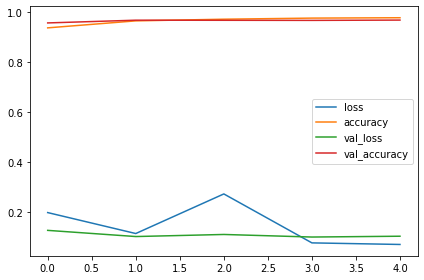

In [ ]:
show_history(history)

In [ ]:
y_test_loss, accuracy = model.evaluate(X_test, y_test)

200/200 [==============================] - 4s 19ms/step - loss: 0.1326 - accuracy: 0.9595


In [ ]:
y_pred = model.predict(X_test).ravel()

#### Sigmoid function gives us real number in range <0, 1>.

#### We need to map this valus to classes

In [ ]:
y_pred

array([5.8227992e-03, 1.5153906e-04, 4.9275317e-04, ..., 9.9427795e-01,
       3.3160646e-05, 3.6857808e-03], dtype=float32)

In [ ]:
y_pred = [1 if x >= 0.5 else 0 for x in y_pred]

# We can see that accuracy is not the best metric in the imbalanced situation - why?
There are many more metrics we can use and one of the most common in this situation is the F1 Score, see [this](https://en.wikipedia.org/wiki/F-score) and [this](https://machinelearningmastery.com/classification-accuracy-is-not-enough-more-performance-measures-you-can-use/) for more info

In [ ]:
accuracy_score(y_true=y_test, y_pred=y_pred)

0.9594869388393555

In [ ]:
f1_score(y_true=y_test, y_pred=y_pred)

0.6852976913730254

In [ ]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      5945
           1       0.75      0.63      0.69       448

    accuracy                           0.96      6393
   macro avg       0.86      0.81      0.83      6393
weighted avg       0.96      0.96      0.96      6393



In [ ]:
print(confusion_matrix(y_true=y_test, y_pred=y_pred))

[[5852   93]
 [ 166  282]]


# We don't have to train our own embedding
There are multiple embeddings available online which were trained on very large corpuses e.g. Wikipedia. Good examples are Word2Vec, Glove or FastText. These embeddings contains fixed length vectors for words in the vocabulary.

We will use GloVe embedding with 50 dimensional embedding vectors. For more details see [this](https://nlp.stanford.edu/projects/glove/).
You can download zip with vectors from [http://nlp.stanford.edu/data/glove.6B.zip](http://nlp.stanford.edu/data/glove.6B.zip) ~ 800 MB

#### Beware that the original text corpus was more general than the specific social media text data, so if you deal with very specific domains it may be beneficial to train your own embedding or at least fine tune existing one.

# We need to download the embedding files
~~~
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip
~~~

50 dims GLOVE is also avaiable here: https://vsb.ai/downloads/glove.6B.50d.txt

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2022-03-12 11:25:40--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-03-12 11:25:40--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-03-12 11:25:40--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
!unzip -q glove.6B.zip

# First we need to load the file to memory and create embedding dictionary

In [ ]:
path_to_glove_file = 'glove.6B.50d.txt'

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
embeddings_index['analysis']

array([ 0.47168 ,  0.25095 ,  0.078363,  0.33009 ,  0.32782 ,  0.47325 ,
        0.16805 , -0.99997 ,  0.8607  ,  0.018286, -0.022716, -0.16986 ,
       -0.33896 ,  0.10096 , -0.29278 , -0.18954 ,  0.063336, -0.64536 ,
       -0.098547, -0.46883 ,  0.26338 , -0.063779,  0.51437 , -0.34739 ,
        0.26537 , -0.58654 , -1.2527  , -0.20557 , -0.31604 ,  0.59308 ,
        2.8329  , -1.2396  , -0.23409 , -1.66    ,  0.047692, -0.23141 ,
       -0.14241 ,  0.74129 ,  0.69887 ,  0.14877 ,  0.6547  , -0.29812 ,
        0.10476 ,  0.56112 , -0.015528,  0.099004,  1.3858  ,  1.8129  ,
        0.3804  ,  0.83921 ], dtype=float32)

## We need to get the voacabulary from the Vectorizer and the integer indexes

In [ ]:
embedding_dim = 50 # Dimension of embedded representation - this is already part of latent space, there is captured some dependecy among words, we are learning this vectors in ANN
vocab_size = 10000 # Number of unique tokens in vocabulary
sequence_length = 20 # Output dimension after vectorizing - words in vectorited representation are independent

vect_layer = TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)
vect_layer.adapt(df.Clean_text.values)

In [ ]:
voc = vect_layer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [ ]:
voc[:10]

['', '[UNK]', 'the', 'to', 'a', 'i', 'you', 'and', 'in', 'for']

In [ ]:
word_index['the']

2

In [ ]:
embeddings_index['the']

array([ 4.1800e-01,  2.4968e-01, -4.1242e-01,  1.2170e-01,  3.4527e-01,
       -4.4457e-02, -4.9688e-01, -1.7862e-01, -6.6023e-04, -6.5660e-01,
        2.7843e-01, -1.4767e-01, -5.5677e-01,  1.4658e-01, -9.5095e-03,
        1.1658e-02,  1.0204e-01, -1.2792e-01, -8.4430e-01, -1.2181e-01,
       -1.6801e-02, -3.3279e-01, -1.5520e-01, -2.3131e-01, -1.9181e-01,
       -1.8823e+00, -7.6746e-01,  9.9051e-02, -4.2125e-01, -1.9526e-01,
        4.0071e+00, -1.8594e-01, -5.2287e-01, -3.1681e-01,  5.9213e-04,
        7.4449e-03,  1.7778e-01, -1.5897e-01,  1.2041e-02, -5.4223e-02,
       -2.9871e-01, -1.5749e-01, -3.4758e-01, -4.5637e-02, -4.4251e-01,
        1.8785e-01,  2.7849e-03, -1.8411e-01, -1.1514e-01, -7.8581e-01],
      dtype=float32)

In [ ]:
num_tokens = len(voc) + 2
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 8500 words (1500 misses)


In [ ]:
embedding_matrix[2]

array([ 4.18000013e-01,  2.49679998e-01, -4.12420005e-01,  1.21699996e-01,
        3.45270008e-01, -4.44569997e-02, -4.96879995e-01, -1.78619996e-01,
       -6.60229998e-04, -6.56599998e-01,  2.78430015e-01, -1.47670001e-01,
       -5.56770027e-01,  1.46579996e-01, -9.50950012e-03,  1.16579998e-02,
        1.02040000e-01, -1.27920002e-01, -8.44299972e-01, -1.21809997e-01,
       -1.68009996e-02, -3.32789987e-01, -1.55200005e-01, -2.31309995e-01,
       -1.91809997e-01, -1.88230002e+00, -7.67459989e-01,  9.90509987e-02,
       -4.21249986e-01, -1.95260003e-01,  4.00710011e+00, -1.85939997e-01,
       -5.22870004e-01, -3.16810012e-01,  5.92130003e-04,  7.44489999e-03,
        1.77780002e-01, -1.58969998e-01,  1.20409997e-02, -5.42230010e-02,
       -2.98709989e-01, -1.57490000e-01, -3.47579986e-01, -4.56370004e-02,
       -4.42510009e-01,  1.87849998e-01,  2.78489990e-03, -1.84110001e-01,
       -1.15139998e-01, -7.85809994e-01])

In [ ]:
show_historyyer = keras.layers.Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(num_tokens, embedding_dim, embeddings_initializer=keras.initializers.Constant(embedding_matrix), trainable=False)(x_v)
x = LSTM(64, activation='relu', return_sequences=True)(emb)
x = GRU(64, activation='relu', return_sequences=False)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(64, 'relu')(x)
x = keras.layers.Dense(32, 'relu')(x)
x = keras.layers.Dropout(0.2)(x)
output_layer = keras.layers.Dense(1, 'sigmoid')(x)

model = keras.Model(input_layer, output_layer)
model.summary()

model.compile(optimizer='rmsprop', loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 20)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 20, 50)            500100    
                                                                 
 lstm_1 (LSTM)               (None, 20, 64)            29440     
                                                                 
 gru_1 (GRU)                 (None, 64)                24960     
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                           

In [ ]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=70, restore_best_weights=True)

batch_size = 128
epochs = 5
history = model.fit(X_train.values, y_train.values, validation_data=(X_valid.values, y_valid.values), callbacks=[es], epochs=epochs, batch_size=batch_size)

Epoch 1/5
180/180 [==============================] - 30s 150ms/step - loss: 0.2314 - accuracy: 0.9290 - val_loss: 0.1642 - val_accuracy: 0.9300
Epoch 2/5
180/180 [==============================] - 27s 152ms/step - loss: 0.1787 - accuracy: 0.9375 - val_loss: 0.1683 - val_accuracy: 0.9437
Epoch 3/5
180/180 [==============================] - 28s 154ms/step - loss: 0.1641 - accuracy: 0.9434 - val_loss: 0.1436 - val_accuracy: 0.9480
Epoch 4/5
180/180 [==============================] - 27s 150ms/step - loss: 0.1534 - accuracy: 0.9469 - val_loss: 0.1378 - val_accuracy: 0.9511
Epoch 5/5
180/180 [==============================] - 27s 149ms/step - loss: 0.1443 - accuracy: 0.9505 - val_loss: 0.1338 - val_accuracy: 0.9515


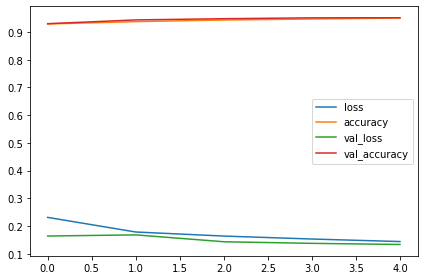

In [ ]:
show_history(history)

In [ ]:
y_pred = model.predict(X_test).ravel()
y_pred = [1 if x >= 0.5 else 0 for x in y_pred]
print(f'Accuracy: {accuracy_score(y_true=y_test, y_pred=y_pred)}')
print(f'F1 Score: {f1_score(y_true=y_test, y_pred=y_pred)}')
print(confusion_matrix(y_true=y_test, y_pred=y_pred))

Accuracy: 0.9444705146253715
F1 Score: 0.5383615084525357
[[5831  114]
 [ 241  207]]


# Task for the lecture
 - Try to create your own architecture
 - Experiment a little - try different batch sizes, optimimizers, time lags as features, etc
 - Send me a link to the Colab notebook with results and description of what you did and your final solution!
 
# There is a competition for bonus points this week!
- Everyone who will send me a correct solution will be included in the F1 - Score toplist
- Deadline for the competition submission is Monday 14th at 23:59
- The toplist will be publicly available on Wednesday
- There is no limitation in used layers (LSTM, CNN, ...), optimizers, etc. 
- You can use any model architecture from the internet including transfer learning,
- The only limitation is that the model has to be trained/fine-tuned on Colab/Kaggle/Your machine so online sentiment scoring services are forbidden!

## The winner with the best F1 - Score on test set will be awarded with 5 bonus points
- The test set is the same as we used in the lecture

# Task for the lecture

## Trainable glove

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 20)               0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 20, 50)            500100    
                                                                 
 lstm_2 (LSTM)               (None, 20, 64)            29440     
                                                                 
 gru_2 (GRU)                 (None, 64)                24960     
                                                                 
 flatten_2 (Flatten)         (None, 64)                0         
                                                           

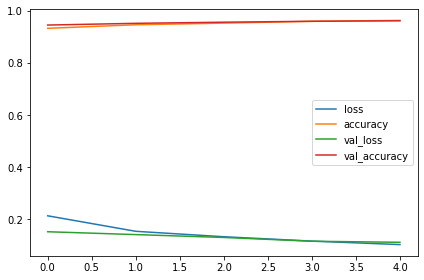

In [ ]:
show_historyyer = keras.layers.Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(num_tokens, embedding_dim, embeddings_initializer=keras.initializers.Constant(embedding_matrix), trainable=True)(x_v)
x = LSTM(64, activation='relu', return_sequences=True)(emb)
x = GRU(64, activation='relu', return_sequences=False)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(64, 'relu')(x)
x = keras.layers.Dense(32, 'relu')(x)
x = keras.layers.Dropout(0.2)(x)
output_layer = keras.layers.Dense(1, 'sigmoid')(x)

model = keras.Model(input_layer, output_layer)
model.summary()

model.compile(optimizer='rmsprop', loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

es = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=70, restore_best_weights=True)

batch_size = 128
epochs = 5
history = model.fit(X_train.values, y_train.values, validation_data=(X_valid.values, y_valid.values), callbacks=[es], epochs=epochs, batch_size=batch_size)

show_history(history)

y_pred = model.predict(X_test).ravel()
y_pred = [1 if x >= 0.5 else 0 for x in y_pred]
print(f'Accuracy: {accuracy_score(y_true=y_test, y_pred=y_pred)}')
print(f'F1 Score: {f1_score(y_true=y_test, y_pred=y_pred)}')
print(confusion_matrix(y_true=y_test, y_pred=y_pred))

# Porovnání vyšlo

- Učení ...0.5909943714821764
- Neučení ... 0.5351351351351351

## Different embedding size

In [ ]:
from_embedding_size = 30
to_embedding_size = 200
step = 20
res = {}

In [ ]:
for embedding_dim in range(from_embedding_size, to_embedding_size, step):
  input_layer = keras.layers.Input(shape=(1,), dtype=tf_string)
  x_v = vect_layer(input_layer)
  emb = keras.layers.Embedding(vocab_size, embedding_dim)(x_v)
  x = LSTM(64, activation='relu', return_sequences=True)(emb)
  x = GRU(64, activation='relu', return_sequences=True)(x)
  x = keras.layers.Flatten()(x)
  x = keras.layers.Dense(64, 'relu')(x)
  x = keras.layers.Dense(32, 'relu')(x)
  x = keras.layers.Dropout(0.2)(x)
  output_layer = keras.layers.Dense(1, 'sigmoid')(x)

  model = keras.Model(input_layer, output_layer)
  model.summary()

  model.compile(optimizer='rmsprop', loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

  es = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=70, restore_best_weights=True)

  batch_size = 128
  epochs = 5
  history = model.fit(X_train.values, y_train.values, validation_data=(X_valid.values, y_valid.values), callbacks=[es], epochs=epochs, batch_size=batch_size)

  y_pred = model.predict(X_test).ravel()
  y_pred = [1 if x >= 0.5 else 0 for x in y_pred]

  f1 = f1_score(y_true=y_test, y_pred=y_pred)

  res[embedding_dim] = f1

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 20)               0         
 ectorization)                                                   
                                                                 
 embedding_3 (Embedding)     (None, 20, 30)            300000    
                                                                 
 lstm_3 (LSTM)               (None, 20, 64)            24320     
                                                                 
 gru_3 (GRU)                 (None, 20, 64)            24960     
                                                                 
 flatten_3 (Flatten)         (None, 1280)              0         
                                                           

In [ ]:
df_res = pd.DataFrame.from_dict(res, orient='index')
df_res.columns = ['f1']
df_res['emb_size'] = df_res.index

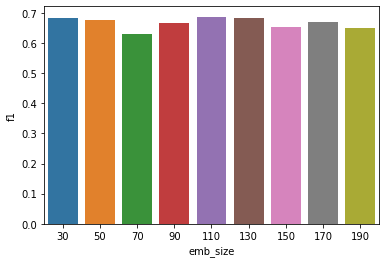

In [ ]:
sns.barplot(x="emb_size", y="f1", data=df_res)

In [ ]:
df_res.head()

,f1,emb_size
30,0.682324,30
50,0.677419,50
70,0.628968,70
90,0.666667,90
110,0.686820,110


In [ ]:
df_res.to_csv("saved_embeddings.csv", sep=';')

## Different model

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 20)               0         
 ectorization)                                                   
                                                                 
 embedding_11 (Embedding)    (None, 20, 190)           1900000   
                                                                 
 lstm_11 (LSTM)              (None, 20, 64)            65280     
                                                                 
 gru_11 (GRU)                (None, 20, 64)            24960     
                                                                 
 flatten_11 (Flatten)        (None, 1280)              0         
                                                          

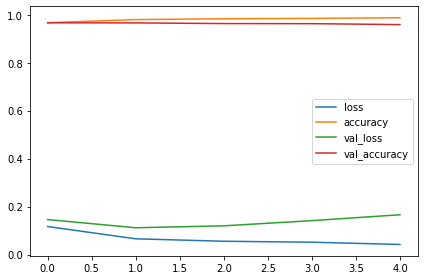

In [ ]:
show_historyyer = keras.layers.Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(num_tokens, 50)(x_v)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(64, 'relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(128, 'relu')(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(64, 'relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(128, 'relu')(x)
x = keras.layers.Dropout(0.2)(x)
output_layer = keras.layers.Dense(1, 'sigmoid')(x)

model = keras.Model(input_layer, output_layer)
model.summary()

model.compile(optimizer='rmsprop', loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

es = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=70, restore_best_weights=True)

batch_size = 128
epochs = 5
history = model.fit(X_train.values, y_train.values, validation_data=(X_valid.values, y_valid.values), callbacks=[es], epochs=epochs, batch_size=batch_size)

show_history(history)

y_pred = model.predict(X_test).ravel()
y_pred = [1 if x >= 0.5 else 0 for x in y_pred]
print(f'Accuracy: {accuracy_score(y_true=y_test, y_pred=y_pred)}')
print(f'F1 Score: {f1_score(y_true=y_test, y_pred=y_pred)}')
print(confusion_matrix(y_true=y_test, y_pred=y_pred))

- Embedding s RNN - **68 cca**
- Embedding s Dense - **66 cca**



# There is a competition for bonus points this week!

- Try to create your own architecture task..

In [36]:
!pip install gensim

In [37]:
!pip install transformers

     |████████████████████████████████| 3.8 MB 3.9 MB/s 
     |████████████████████████████████| 895 kB 46.5 MB/s 
     |████████████████████████████████| 67 kB 5.1 MB/s 
     |████████████████████████████████| 6.5 MB 25.0 MB/s 
     |████████████████████████████████| 596 kB 47.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [38]:
df_transformers = df.copy()

In [39]:
LABEL_KEY = 'Clean_text_1'

In [40]:
from gensim.parsing.preprocessing import remove_stopwords, preprocess_string

In [41]:
def super_normalization(text):
  return " ".join(preprocess_string(text))

In [42]:
df_transformers[LABEL_KEY] = df_transformers.Clean_text.apply(super_normalization)

In [43]:
df_transformers.head()

,id,label,tweet,length,Words,Words_normalized,Words_normalized_no_user,Words_normalized_no_user_fixed,Clean_text,Clean_text_1
0,1,0,@user when a father is dysfunctional and is s...,102,"[user, when, a, father, is, dysfunctional, and...","[user, when, a, father, is, dysfunctional, and...","[when, a, father, is, dysfunctional, and, is, ...","[when, a, father, is, dysfunctional, and, is, ...",when a father is dysfunctional and is so selfi...,father dysfunct selfish drag kid dysfunct
1,2,0,@user @user thanks for #lyft credit i can't us...,122,"[user, user, thanks, for, lyft, credit, i, ca,...","[user, user, thanks, for, lyft, credit, i, ca,...","[thanks, for, lyft, credit, i, ca, n't, use, c...","[thanks, for, lyft, credit, i, can't, use, cau...",thanks for lyft credit i can't use cause they ...,thank lyft credit us caus offer wheelchair van...
2,3,0,bihday your majesty,21,"[bihday, your, majesty]","[bihday, your, majesty]","[bihday, your, majesty]","[bihday, your]",bihday your,bihdai
3,4,0,#model i love u take with u all the time in ...,86,"[model, i, love, u, take, with, u, all, the, t...","[model, i, love, u, take, with, u, all, the, t...","[model, i, love, u, take, with, u, all, the, t...","[model, i, love, u, take, with, u, all, the, t...",model i love u take with u all the time in,model love time
4,5,0,factsguide: society now #motivation,39,"[factsguide, society, now, motivation]","[factsguide, society, now, motivation]","[factsguide, society, now, motivation]","[factsguide, society, now]",factsguide society now,factsguid societi


In [44]:
SELECTION_KEY = "Clean_text"

X_train, X_test, y_train, y_test = train_test_split(df_transformers[SELECTION_KEY], df_transformers.label, test_size=0.20, random_state=13, stratify=df_transformers.label)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=13, stratify=y_train)

print(X_train.shape, X_test.shape)

(23012,) (6393,)


In [45]:
df_transformers.label.value_counts()

# 0 = positive
# 1 = negative

0    29720
1     2242
Name: label, dtype: int64

In [46]:
res_transformers = {}

# Twitter-roBERTa-base for Sentiment Analysis

In [ ]:
name_1 = "Twitter-roBERTa-base for Sentiment Analysis"

 https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment?text=model+i+love+u+take+with+u+all+the+time+in

In [47]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
from collections import Counter

In [ ]:
#Labels: 
# 0 -> Negative; 
# 1 -> Neutral; 
# 2 -> Positive

task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

tokenizer = AutoTokenizer.from_pretrained(MODEL)

model = TFAutoModelForSequenceClassification.from_pretrained(MODEL)

Downloading:   0%|          | 0.00/747 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [ ]:
model.summary()

Model: "tf_roberta_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLayer  multiple                 124055040 
 )                                                               
                                                                 
 classifier (TFRobertaClassi  multiple                 592899    
 ficationHead)                                                   
                                                                 
Total params: 124,647,939
Trainable params: 124,647,939
Non-trainable params: 0
_________________________________________________________________


In [ ]:
X_test.shape

(6393,)

In [ ]:
pred_sentences = list(X_test.values)[0:1000]
y_test_transformer = y_test[0:1000]

In [ ]:
#longest has 42

tf_batch = tokenizer(pred_sentences, max_length=30, padding=True, truncation=True, return_tensors='tf')

In [ ]:
tf_outputs = model(tf_batch)

tf_predictions = tf.nn.softmax(
    tf_outputs[0], 
    axis=-1
)

In [48]:
def get_labels(predictions):
  negative = predictions[:, 0]
  positive = predictions[:, 2]
  return np.column_stack((positive, negative))

In [ ]:
predictions_without_neutral = get_labels(tf_predictions)

predicted = tf.argmax(
    predictions_without_neutral, 
    axis=1
).numpy()

In [ ]:
predicted

array([0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,

In [49]:
def get_y_true_y_pred(y_test, y_predicted):
   f1 = f1_score(y_true=y_test, y_pred=y_predicted)
   return f1

In [ ]:
f1_1 = get_y_true_y_pred(y_test_transformer, predicted)

NameError: ignored

In [ ]:
res_transformers[name_1] = f1_1

In [102]:
MAX_SEQUENCE_LENGTH = 40
MODEL_NAME = 'distilbert-base-uncased'

In [51]:
from transformers import (
    DistilBertTokenizerFast,
    TFDistilBertModel,
)

In [52]:
tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)


def tokenize(sentences, max_length=MAX_SEQUENCE_LENGTH, padding='max_length'):
    return tokenizer(
        sentences,
        truncation=True,
        padding=padding,
        max_length=max_length,
        return_tensors="tf"
    )

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [53]:
def get_raw_ds(input_df):
  copy_df = input_df.copy()

  print(copy_df.label.value_counts())

  SELECTION_KEY = "Clean_text"

  X_train, X_test, y_train, y_test = train_test_split(copy_df[SELECTION_KEY], copy_df.label, test_size=0.20, random_state=13, stratify=copy_df.label)

  X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=13, stratify=y_train)

  return X_train, y_train, X_valid, y_valid, X_test, y_test


In [54]:
def balance(input_df):
  copy_df = input_df.copy()
  positive = copy_df[copy_df.label == 0]

  negative = copy_df[copy_df.label == 1]

  number_times = int(len(positive) / len(negative))

  negative = negative.sample(n=len(negative)*number_times, replace=True)
  
  return pd.concat([negative, positive])

In [55]:
def get_balanced_ds(input_df):
  SELECTION_KEY = "Clean_text"
  copy_df = input_df.copy()

  X_train, X_test, y_train, y_test = train_test_split(copy_df[SELECTION_KEY], copy_df.label, test_size=0.20, random_state=13, stratify=copy_df.label)

  x = pd.DataFrame()
  x[SELECTION_KEY] = X_train
  x['label'] = y_train

  copy_df = balance(x)

  X_train, X_valid, y_train, y_valid = train_test_split(copy_df[SELECTION_KEY], copy_df.label, test_size=0.1, random_state=13, stratify=copy_df.label)

  return X_train, y_train, X_valid, y_valid, X_test, y_test

# GRU with Glove

In [ ]:
import gensim.downloader as api
import gzip

In [ ]:
NAME_OF_MODEL_FASTTEXT = "fasttext-wiki-news-subwords-300"
NAME_OF_MODEL_GLOVE = "glove-twitter-200"

In [ ]:
model = api.load(NAME_OF_MODEL_GLOVE)  # load glove vectors

[==================================================] 100.0% 758.5/758.5MB downloaded


In [ ]:
def load_model(File):
    """Gensim library can load file which contains embedding. This method unzip file and created dictionary word to embedding vector.

    @param File: path to file

    @return: created embedding dictionary word to embedding vector
    """
    with gzip.open(File, 'r') as f:
        model = {}
        for line in f:        
            splitLines = line.split()
            word = splitLines[0].decode("utf-8")
            wordEmbedding = np.array([float(value) for value in splitLines[1:]])
            model[word] = wordEmbedding
    print(len(model)," words loaded!")
    return model


In [ ]:
loaded_model_path = api.load(NAME_OF_MODEL_GLOVE, return_path=True)

In [ ]:
embedding_dictionary = load_model(loaded_model_path)

1193515  words loaded!


In [ ]:
def prepare_embeddings_matrix(input_dic, embedding_dimension, vocab):
    num_tokens = len(vocab)
        
    num_tokens = len(voc) + 2
    hits = 0
    misses = 0
    
    
    embedding_matrix = np.zeros((num_tokens, embedding_dimension))
    for i, word in enumerate(vocab):
        embedding_vector = None
        if word in input_dic:
            embedding_vector = input_dic[word]
            
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1

    print("Converted %d words (%d misses)" % (hits, misses))
    return embedding_matrix, num_tokens


# GRU LSTM b and FASTTEXT

In [ ]:
name_gru_lstm_fasttext = "GRU LSTM b and FASTTEXT"
train_data, train_label, validation_data, validation_label, test_data, test_label = get_raw_ds(df_transformers.copy())

loaded_model_path = api.load(NAME_OF_MODEL_FASTTEXT, return_path=True)
embedding_dictionary = load_model(loaded_model_path)

In [ ]:
embedding_dim = 300
vocab_size = 20000
sequence_length = 30

vect_layer = TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)
vect_layer.adapt(df.Clean_text.values)

voc = vect_layer.get_vocabulary()

In [ ]:
embedding_matrix, num_tokens = prepare_embeddings_matrix(embedding_dictionary, 300, vect_layer.get_vocabulary())

Converted 13536 words (6464 misses)


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_6 (TextV  (None, 30)               0         
 ectorization)                                                   
                                                                 
 embedding_4 (Embedding)     (None, 30, 300)           6000600   
                                                                 
 bidirectional_2 (Bidirectio  (None, 30, 128)          186880    
 nal)                                                            
                                                                 
 gru_2 (GRU)                 (None, 64)                37248     
                                                                 
 dense_8 (Dense)             (None, 128)               8320

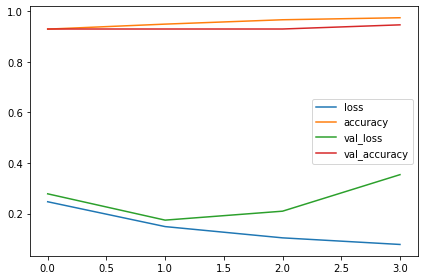

In [ ]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf_string)

x_v = vect_layer(input_layer)

emb = keras.layers.Embedding(num_tokens, embedding_dim, embeddings_initializer=keras.initializers.Constant(embedding_matrix), trainable=True)(x_v)

x = keras.layers.Bidirectional(keras.layers.LSTM(64, activation='relu', return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(emb)
x = keras.layers.GRU(64, activation='relu', return_sequences=False)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(32, 'relu')(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(64, 'relu')(x)
output_layer = keras.layers.Dense(1, 'sigmoid')(x)

model = keras.Model(input_layer, output_layer)
model.summary()

model.compile(optimizer='rmsprop', loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

es = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=2, restore_best_weights=True)

batch_size = 128
epochs = 5


history = model.fit(train_data.values, train_label.values, validation_data=(validation_data.values, validation_label.values), callbacks=[es], epochs=epochs, batch_size=batch_size)

show_history(history)

In [ ]:
y_pred = model.predict(test_data.values).ravel()
y_pred = [1 if x >= 0.5 else 0 for x in y_pred]

f1_1 = get_y_true_y_pred(test_label.values, y_pred)

res_transformers[name_gru_lstm_fasttext] = f1_1

In [ ]:
Counter(y_pred)

Counter({0: 6393})

In [ ]:
test_label.value_counts()

0    5945
1     448
Name: label, dtype: int64

In [ ]:
res_transformers

{'GRU LSTM b and FASTTEXT': 0.0,
 'GRU LSTM b and GLOVE twitter': 0.6237762237762238}

# GRU LSTM b and GLOVE twitter

> Odsazený blok



In [ ]:
name_gru_glove_twitter = "GRU LSTM b and GLOVE twitter"
train_data, train_label, validation_data, validation_label, test_data, test_label = get_raw_ds(df_transformers.copy())

loaded_model_path = api.load(NAME_OF_MODEL_GLOVE, return_path=True)
embedding_dictionary = load_model(loaded_model_path)

embedding_dim = 200
vocab_size = 20000
sequence_length = 30

vect_layer = TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)
vect_layer.adapt(df.Clean_text.values)

voc = vect_layer.get_vocabulary()

0    29720
1     2242
Name: label, dtype: int64
1193515  words loaded!


In [ ]:
embedding_matrix, num_tokens = prepare_embeddings_matrix(embedding_dictionary, 200, vect_layer.get_vocabulary())

Converted 15607 words (4393 misses)


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_7 (TextV  (None, 30)               0         
 ectorization)                                                   
                                                                 
 embedding_5 (Embedding)     (None, 30, 200)           4000400   
                                                                 
 bidirectional_3 (Bidirectio  (None, 30, 128)          135680    
 nal)                                                            
                                                                 
 gru_3 (GRU)                 (None, 64)                37248     
                                                                 
 batch_normalization_3 (Batc  (None, 64)               256 

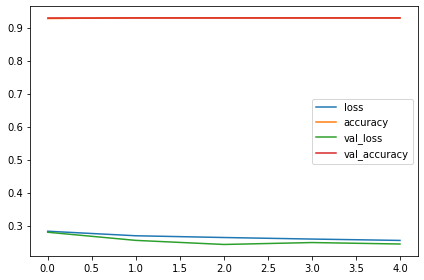

In [ ]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf_string)

x_v = vect_layer(input_layer)

emb = keras.layers.Embedding(num_tokens, embedding_dim, embeddings_initializer=keras.initializers.Constant(embedding_matrix), trainable=True)(x_v)

x = keras.layers.Bidirectional(keras.layers.LSTM(64, activation='relu', return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(emb)
x = keras.layers.GRU(64, activation='relu', return_sequences=False)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(64, 'relu')(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(16, 'relu')(x)
output_layer = keras.layers.Dense(1, 'sigmoid')(x)

model = keras.Model(input_layer, output_layer)
model.summary()

model.compile(optimizer='rmsprop', loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

es = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=2, restore_best_weights=True)

batch_size = 64
epochs = 5


history = model.fit(train_data.values, train_label.values, validation_data=(validation_data.values, validation_label.values), callbacks=[es], epochs=epochs, batch_size=batch_size)

show_history(history)

In [ ]:
y_pred = model.predict(test_data.values).ravel()
y_pred = [1 if x >= 0.5 else 0 for x in y_pred]

f1_1 = get_y_true_y_pred(test_label.values, y_pred)

res_transformers[name_gru_glove_twitter] = f1_1

In [ ]:
res_transformers

{'GRU LSTM b and FASTTEXT': 0.0, 'GRU LSTM b and GLOVE twitter': 0.0}

# GRU LSTM b and GLOVE

In [ ]:
name_gru = "GRU with GLOVE"
train_data, train_label, validation_data, validation_label, test_data, test_label = get_raw_ds(df_transformers.copy())

embedding_dim = 50
vocab_size = 13000 
sequence_length = 30

vect_layer = TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)
vect_layer.adapt(df.Clean_text.values)

voc = vect_layer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

num_tokens = len(voc) + 2
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

0    29720
1     2242
Name: label, dtype: int64
Converted 10586 words (2414 misses)


In [ ]:
embedding_matrix.shape

(13002, 50)

In [ ]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf_string)

x_v = vect_layer(input_layer)

emb = keras.layers.Embedding(num_tokens, embedding_dim, embeddings_initializer=keras.initializers.Constant(embedding_matrix), trainable=True)(x_v)

x = keras.layers.Bidirectional(keras.layers.LSTM(64, activation='relu', return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(emb)
x = keras.layers.GRU(64, activation='relu', return_sequences=False)(x)
x = keras.layers.Dense(128, 'relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(64, 'relu')(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(64, 'relu')(x)
x = keras.layers.Dropout(0.2)(x)
output_layer = keras.layers.Dense(1, 'sigmoid')(x)

model = keras.Model(input_layer, output_layer)
model.summary()

model.compile(optimizer='rmsprop', loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

es = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, restore_best_weights=True)

batch_size = 32
epochs = 5


history = model.fit(train_data.values, train_label.values, validation_data=(validation_data.values, validation_label.values), callbacks=[es], epochs=epochs, batch_size=batch_size)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_2 (TextV  (None, 30)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 30, 50)            650100    
                                                                 
 bidirectional (Bidirectiona  (None, 30, 128)          58880     
 l)                                                              
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense (Dense)               (None, 128)               8320  

KeyboardInterrupt: ignored

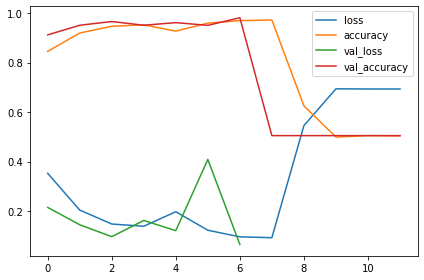

In [ ]:
show_history(history)

In [ ]:
y_pred = model.predict(test_data.values).ravel()
y_pred = [1 if x >= 0.5 else 0 for x in y_pred]

f1_1 = get_y_true_y_pred(test_label.values, y_pred)

res_transformers[name_gru] = f1_1

# Learning DistilBERT - trainable

In [58]:
name_3 = "Learning BERT - trainable"

NUM_EPOCHS = 10
BATCH_SIZE = 32
LEARNING_RATE = 5e-5
EARLY_STOP_PATIENCE = 3

train_data, train_label, validation_data, validation_label, test_data, test_label = get_raw_ds(df_transformers.copy())

base = TFDistilBertModel.from_pretrained(
    MODEL_NAME,
)

input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='attention_mask')

output = base([input_ids, attention_mask]).last_hidden_state[:, 0, :]

output = tf.keras.layers.Dropout(
    rate=0.15,
)(output)
    
output = tf.keras.layers.Dense(
    units=64,
    activation='relu',
)(output)

output = tf.keras.layers.BatchNormalization()(output)

output = tf.keras.layers.Dense(
    units=64,
    activation='relu',
)(output)

output = tf.keras.layers.BatchNormalization()(output)

output_layer = tf.keras.layers.Dense(
    units=1,
    activation='sigmoid'
)(output)


model = keras.Model(inputs=[input_ids, attention_mask], outputs=output_layer)

model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

es = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=EARLY_STOP_PATIENCE, restore_best_weights=True)

0    29720
1     2242
Name: label, dtype: int64


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_projector', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 40)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 40)]         0           []                               
                                                                                                  
 tf_distil_bert_model_2 (TFDist  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 ilBertModel)                   ast_hidden_state=(N               'attention_mask[0][0]']         
                                one, 40, 768),                                                    
                                 hidden_states=None                                         

In [59]:
X = tf.data.Dataset.from_tensor_slices((
    dict(tokenize(list(train_data))),
    train_label
)).batch(BATCH_SIZE).prefetch(1)


V = tf.data.Dataset.from_tensor_slices((
    dict(tokenize(list(validation_data))),
    validation_label
)).batch(BATCH_SIZE).prefetch(1)

T = tf.data.Dataset.from_tensor_slices((
    dict(tokenize(list(test_data))),
    test_label
)).batch(1).prefetch(1)

In [60]:
history = model.fit(
    X,
    epochs=NUM_EPOCHS,
    validation_data=V,
    callbacks=[
      es
    ]
)

Epoch 1/10
720/720 [==============================] - 221s 291ms/step - loss: 0.5739 - accuracy: 0.7794 - val_loss: 0.3575 - val_accuracy: 0.9562
Epoch 2/10
720/720 [==============================] - 207s 288ms/step - loss: 0.3769 - accuracy: 0.9319 - val_loss: 0.2855 - val_accuracy: 0.9562
Epoch 3/10
720/720 [==============================] - 207s 287ms/step - loss: 0.2560 - accuracy: 0.9624 - val_loss: 0.3972 - val_accuracy: 0.9515
Epoch 4/10
720/720 [==============================] - 207s 287ms/step - loss: 0.1840 - accuracy: 0.9738 - val_loss: 0.2895 - val_accuracy: 0.9609
Epoch 5/10
720/720 [==============================] - 208s 289ms/step - loss: 0.1140 - accuracy: 0.9857 - val_loss: 0.3298 - val_accuracy: 0.9605


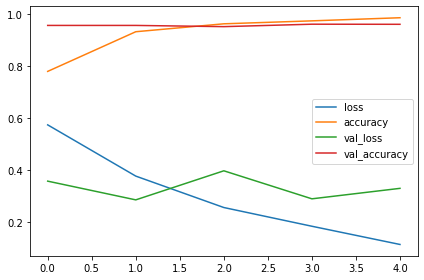

In [61]:
show_history(history)

In [62]:
labels = model.predict(T)

predicted = [1 if x >= 0.5 else 0 for x in labels.ravel()]

f1_1 = get_y_true_y_pred(test_label, predicted)

res_transformers[name_3] = f1_1

# Bert trainable

In [64]:
from transformers import TFAutoModel
from transformers import AutoTokenizer

In [67]:
BERT_MODEL_NAME = "bert-base-uncased"

In [68]:
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_NAME)


def tokenize(sentences, max_length=MAX_SEQUENCE_LENGTH, padding='max_length'):
    return tokenizer(
        sentences,
        truncation=True,
        padding=padding,
        max_length=max_length,
        return_tensors="tf"
    )

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [69]:
name_4 = "Learning BERT (no distil) - trainable"

NUM_EPOCHS = 10
BATCH_SIZE = 32
LEARNING_RATE = 5e-5
EARLY_STOP_PATIENCE = 3

train_data, train_label, validation_data, validation_label, test_data, test_label = get_raw_ds(df_transformers.copy())

base = TFAutoModel.from_pretrained(
    BERT_MODEL_NAME,
)

input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='attention_mask')

output = base([input_ids, attention_mask]).last_hidden_state[:, 0, :]

output = tf.keras.layers.Dropout(
    rate=0.15,
)(output)
    
output = tf.keras.layers.Dense(
    units=64,
    activation='relu',
)(output)

output = tf.keras.layers.BatchNormalization()(output)

output = tf.keras.layers.Dense(
    units=64,
    activation='relu',
)(output)

output = tf.keras.layers.BatchNormalization()(output)

output_layer = tf.keras.layers.Dense(
    units=1,
    activation='sigmoid'
)(output)


model = keras.Model(inputs=[input_ids, attention_mask], outputs=output_layer)

model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

es = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=EARLY_STOP_PATIENCE, restore_best_weights=True)

0    29720
1     2242
Name: label, dtype: int64


Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 40)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 40)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 40,                                          

In [70]:
X = tf.data.Dataset.from_tensor_slices((
    dict(tokenize(list(train_data))),
    train_label
)).batch(BATCH_SIZE).prefetch(1)


V = tf.data.Dataset.from_tensor_slices((
    dict(tokenize(list(validation_data))),
    validation_label
)).batch(BATCH_SIZE).prefetch(1)

T = tf.data.Dataset.from_tensor_slices((
    dict(tokenize(list(test_data))),
    test_label
)).batch(1).prefetch(1)

In [71]:
history = model.fit(
    X,
    epochs=NUM_EPOCHS,
    validation_data=V,
    callbacks=[
      es
    ]
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['token_type_ids'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


720/720 [==============================] - 421s 557ms/step - loss: 0.5883 - accuracy: 0.7623 - val_loss: 0.6690 - val_accuracy: 0.4638
Epoch 2/10
720/720 [==============================] - 401s 557ms/step - loss: 0.4207 - accuracy: 0.8958 - val_loss: 0.2533 - val_accuracy: 0.9574
Epoch 3/10
720/720 [==============================] - 396s 550ms/step - loss: 0.2931 - accuracy: 0.9535 - val_loss: 0.1966 - val_accuracy: 0.9609
Epoch 4/10
720/720 [==============================] - 399s 553ms/step - loss: 0.2074 - accuracy: 0.9704 - val_loss: 0.2821 - val_accuracy: 0.9609
Epoch 5/10
720/720 [==============================] - 399s 554ms/step - loss: 0.2689 - accuracy: 0.9393 - val_loss: 0.7152 - val_accuracy: 0.6433
Epoch 6/10
720/720 [==============================] - 398s 553ms/step - loss: 0.2444 - accuracy: 0.9452 - val_loss: 0.2655 - val_accuracy: 0.9300


In [72]:
labels = model.predict(T)

predicted = [1 if x >= 0.5 else 0 for x in labels.ravel()]

f1_1 = get_y_true_y_pred(test_label, predicted)

res_transformers[name_4] = f1_1

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['token_type_ids'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


In [73]:
res_transformers

{'Learning BERT (no distil) - trainable': 0.6083086053412462,
 'Learning BERT - trainable': 0.6719636776390465}

# Bert trainable oversampled

In [106]:
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_NAME)


def tokenize(sentences, max_length=MAX_SEQUENCE_LENGTH, padding='max_length'):
    return tokenizer(
        sentences,
        truncation=True,
        padding=padding,
        max_length=max_length,
        return_tensors="tf"
    )

In [107]:
name_5 = "Learning BERT (no distil) - trainable oversampled"

NUM_EPOCHS = 10
BATCH_SIZE = 32
LEARNING_RATE = 5e-5
EARLY_STOP_PATIENCE = 3

train_data, train_label, validation_data, validation_label, test_data, test_label = get_balanced_ds(df_transformers.copy())

base = TFAutoModel.from_pretrained(
    BERT_MODEL_NAME,
)

input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='attention_mask')

output = base([input_ids, attention_mask]).last_hidden_state[:, 0, :]

output = tf.keras.layers.Dropout(
    rate=0.15,
)(output)
    
output = tf.keras.layers.Dense(
    units=64,
    activation='relu',
)(output)

output = tf.keras.layers.BatchNormalization()(output)

output = tf.keras.layers.Dense(
    units=64,
    activation='relu',
)(output)

output = tf.keras.layers.BatchNormalization()(output)

output_layer = tf.keras.layers.Dense(
    units=1,
    activation='sigmoid'
)(output)


model = keras.Model(inputs=[input_ids, attention_mask], outputs=output_layer)

model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

es = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=EARLY_STOP_PATIENCE, restore_best_weights=True)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 40)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 40)]         0           []                               
                                                                                                  
 tf_bert_model_7 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 40,                                         

In [108]:
X = tf.data.Dataset.from_tensor_slices((
    dict(tokenize(list(train_data))),
    train_label
)).batch(BATCH_SIZE).prefetch(1)


V = tf.data.Dataset.from_tensor_slices((
    dict(tokenize(list(validation_data))),
    validation_label
)).batch(BATCH_SIZE).prefetch(1)

T = tf.data.Dataset.from_tensor_slices((
    dict(tokenize(list(test_data))),
    test_label
)).batch(1).prefetch(1)

In [109]:
combined_dataset = X.concatenate(V)

In [110]:
history = model.fit(
    combined_dataset,
    epochs=1
)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['token_type_ids'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1473/1473 [==============================] - 832s 551ms/step - loss: 0.1376 - accuracy: 0.9482


In [111]:
labels = model.predict(T)

predicted = [1 if x >= 0.5 else 0 for x in labels.ravel()]

f1_1 = get_y_true_y_pred(test_label, predicted)

res_transformers[name_5] = f1_1

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['token_type_ids'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


In [112]:
res_transformers

{'Learning BERT (no distil) - trainable': 0.6083086053412462,
 'Learning BERT (no distil) - trainable oversampled': 0.7224880382775121,
 'Learning BERT (no distil) - trainable oversampledtrain+valid': 0.7631901840490797,
 'Learning BERT (no distil) - trainable oversampledtrain+valid+1': 0.7212765957446808,
 'Learning BERT (no distil) - trainable oversampledtrain+valid+2': 0.7228070175438597,
 'Learning BERT (no distil) - trainable oversampledtrain+valid+3': 0.723699421965318,
 'Learning BERT - trainable': 0.6719636776390465}

# Results

In [115]:
df = pd.DataFrame.from_dict(res_transformers, orient="index")

In [116]:
df.columns=['f1']

In [120]:
df.sort_values(by='f1', ascending=False)

,f1
Learning BERT (no distil) - trainable oversampledtrain+valid,0.763190
Learning BERT (no distil) - trainable oversampledtrain+valid+3,0.723699
Learning BERT (no distil) - trainable oversampledtrain+valid+2,0.722807
Learning BERT (no distil) - trainable oversampled,0.722488
Learning BERT (no distil) - trainable oversampledtrain+valid+1,0.721277
Learning BERT - trainable,0.671964
Learning BERT (no distil) - trainable,0.608309
